# 时间序列


## 格力利润分析


1996-2020年半年财报


2002-2020年季报

# 程序执行


## 加载库

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import matplotlib.dates as mdates

from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import math
import os
import copy
import itertools
import seaborn as sns #热力图

plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 加载数据


利润表gree-benefit.xlsx


两个不同的sheet显示半年报以及季度报


In [2]:
class TimeSeries:
    def __init__(self, df, name):
        """
        时间序列分析
        """
        self.origin = df
        self.name = name
        self.data = self.getSeries()
        self.dataset = [self.data]
        self.armaModel = None
        self.step = 0
    def getSeries(self):
        """
        按照时间序列需求处理数据
        """
        data = pd.DataFrame({'timeSeries': self.origin['营业总收入']})
        data.index = pd.to_datetime(self.origin['会计期间'])
        data['timeSeries'] = data['timeSeries'].map(lambda x: x / 1000000)
        data.columns = [self.name]
        return data
    def baseShow(self, step=0):
        """
        基本显示
        """
        df = self.dataset[step]
        fig, ax = plt.subplots(figsize=(15, 6))
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.plot(df)
        ax.set_ylabel('营业总收入(百万元)')
        fig.suptitle(self.name)
    def acfShow(self, step=0):
        """
        自相关性
        """
        df = self.dataset[step]
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        plot_acf(df, ax=axes[0])
        plot_pacf(df, ax=axes[1])
        fig.suptitle(self.name)
        plt.show()
    def dickey(self, step=0):
        """
        单位跟检验
        """
        t = adfuller(self.dataset[step])
        output = pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['value'])
        output['value']['Test Statistic Value'] = t[0]
        output['value']['p-value'] = t[1]
        output['value']['Lags Used'] = t[2]
        output['value']['Number of Observations Used'] = t[3]
        output['value']['Critical Value(1%)'] = t[4]['1%']
        output['value']['Critical Value(5%)'] = t[4]['5%']
        output['value']['Critical Value(10%)'] = t[4]['10%']
        return output
    def seaon(self, freq, step=0):
        """
        得到如下的分解图形——原始数据、趋势数据、周期性数据、随机变量
        """
        rd = sm.tsa.seasonal_decompose(self.dataset[step].values, freq=freq)
        rd.plot()
    def ic(self, step=0):
        return sm.tsa.arma_order_select_ic(self.dataset[step], ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=2)
    def thermodynamicOrder(self, ar=4, ma=2, step=0):
        """
        order热力图
        """
        # 创建Dataframe,以BIC准则
        results_aic = pd.DataFrame(\
            index=['AR{}'.format(i) for i in range(0, ar+1)],\
            columns=['MA{}'.format(i) for i in range(0, ma+1)])
        for p, q in itertools.product(range(0, ar+1), range(0, ma+1)):
            if p==0 and q==0:
                results_aic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
                continue
            try:
                results = self.arma((p, q), step)
                #返回不同pq下的model的BIC值
                results_aic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.aic
            except:
                continue
        results_aic = results_aic[results_aic.columns].astype(float)
        fig, ax = plt.subplots(figsize=(10, 8))
        ax = sns.heatmap(results_aic,
                        #mask=results_aic.isnull(),
                        ax=ax,
                        annot=True, #将数字显示在热力图上
                        fmt='.2f',
                        )
        ax.set_title('AIC')
        plt.show()
    def arma(self, order, step=0):
        """
        创建arma模型
        """
        self.step = step
        self.armaModel = ARMA(self.dataset[step], order).fit()
        return self.armaModel
    def qqShow(self, step=0):
        """
        qq图
        """
        resid = self.armaModel.resid
        fig, ax = plt.subplots(figsize=(10, 6))
        qqplot(resid,line='q',ax=ax,fit=True)
        plt.show()
    def predict(self, start, end):
        """
        预测
        """
        series = self.data[self.name]
        fig, ax = plt.subplots(figsize=(15, 6))
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.plot(self.data, 'r', label='原始数据')
        ax.plot(self.armaModel.fittedvalues.index, self.revert(self.armaModel.fittedvalues, self.data[self.name][0]), 'g', label='ARMA模型')
        furture = self.armaModel.predict(start=start, end=end)
        r = self.revert(furture, self.data[self.name][-1])
        ax.plot(furture.index, r, 'b', label='预测数据')
        ax.legend()
        ax.set_ylabel('营业总收入(百万元)')
        fig.suptitle(self.name)
    def revert(self, diffValues, *lastValue):
        for i in range(len(lastValue)):
            result = []
            lv = lastValue[i]
            for dv in diffValues:
                lv = dv + lv
                result.append(lv)
            diffValues = result
        return diffValues
    def diff(self):
        """
        差分
        """
        df = self.dataset[len(self.dataset)- 1]
        D_data = df.diff().dropna()
        self.dataset.append(D_data)
quarter = TimeSeries(pd.read_excel('格力利润表1996-2020.09.xlsx', sheet_name='季度不累计'), '季报')
semiannum = TimeSeries(pd.read_excel('格力利润表1996-2020.09.xlsx', sheet_name='半年不累计'), '半年报')

# 数据


## 季报


2002-2020

In [3]:
quarter.origin.head()

,证券代码,会计期间,营业总收入
0,651,2002-03-31,1.008806e+09
1,651,2002-06-30,2.463584e+09
2,651,2002-09-30,1.941673e+09
3,651,2002-12-31,1.615627e+09
4,651,2003-03-31,1.617768e+09


## 半年报


1996-2020

In [4]:
semiannum.origin.head()

,证券代码,会计期间,营业总收入
0,651,1996-06-30,1.867635e+09
1,651,1996-12-31,9.735888e+08
2,651,1997-06-30,2.061179e+09
3,651,1997-12-31,1.390483e+09
4,651,1998-06-30,2.457115e+09


## 时间序列图表


### 季报图表

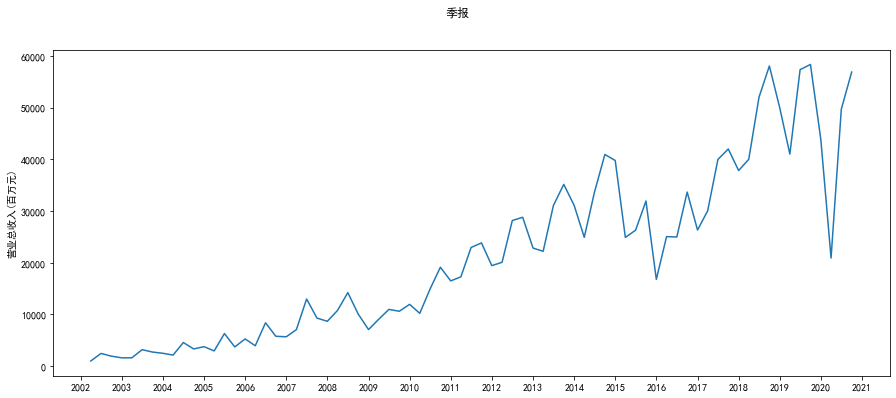

In [5]:
quarter.baseShow()

## 半年报图表

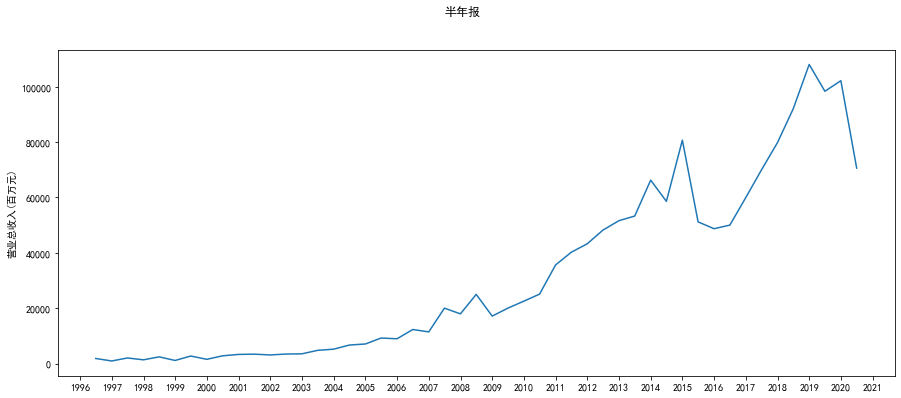

In [6]:
semiannum.baseShow()

季度统计数据内容比较多，半年统计数据时间跨度比较长，各有优缺点，分开分析

## 单位根检验（Dickey-Fuller test）


p-value较高，序列具有单位根，即非平稳。

# 自相关


绘制自相关图，判断序列是否自相关


## 季报自相关图

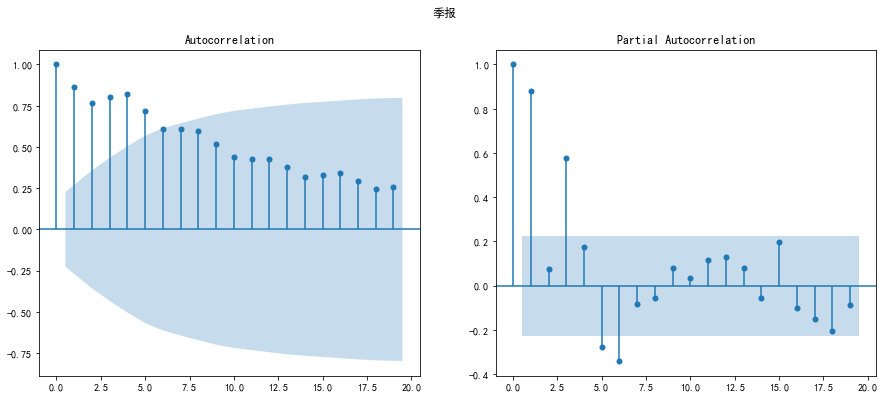

In [7]:
quarter.acfShow()

由自相关图可以看出，在6阶后才落入区间内，并且自相关系数都大于零，显示出很强的自相关性。


## 半年报自相关图

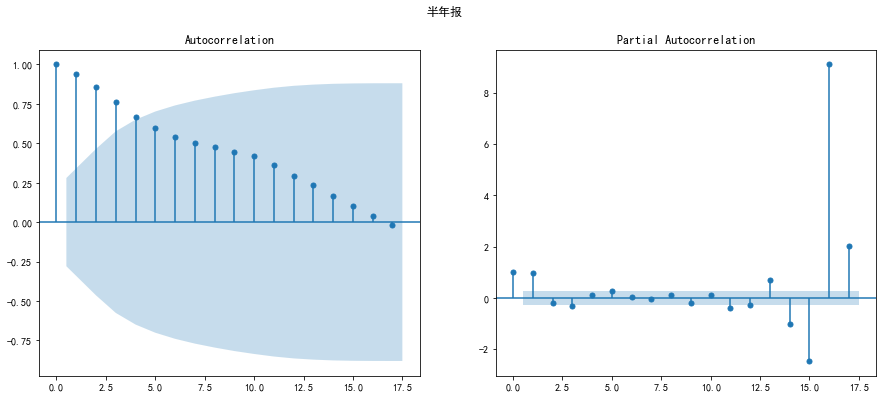

In [8]:
semiannum.acfShow()

由自相关图可以看出，在5阶后才落入区间内，并且自相关系数都大于零，显示出很强的自相关性。


# 平稳性检验


## 季报平稳性

In [9]:
quarter.dickey()

,value
Test Statistic Value,-0.859104
p-value,0.801142
Lags Used,6
Number of Observations Used,68
Critical Value(1%),-3.530399
Critical Value(5%),-2.905087
Critical Value(10%),-2.590001


如何确定该序列能否平稳呢？主要看：

1%、%5、%10不同程度拒绝原假设的统计值和ADF Test result的比较，ADF Test result同时小于1%、5%、10%即说明非常好地拒绝该假设，本数据中，adf结果（Test Statistic）为-0.859104， 大于三个level的统计值(-3.530399, -2.905087, -2.590001)。

看P-value是否非常接近0. 本数据中，P-value 为 0.801142,不够接近0。

ADF检验的原假设是存在单位根，只要这个统计值是小于1%水平下的数字就可以极显著的拒绝原假设，认为数据平稳。注意，ADF值一般是负的，也有正的，但是它只有小于1%水平下的才能认为是及其显著的拒绝原假设。

对于ADF结果在1% 以上 5%以下的结果，也不能说不平稳，关键看检验要求是什么样子的。

但是对于本例，，数据是显然不平稳的了。


## 半年报平稳性

In [10]:
semiannum.dickey()

,value
Test Statistic Value,1.699264
p-value,0.998127
Lags Used,7
Number of Observations Used,41
Critical Value(1%),-3.600983
Critical Value(5%),-2.935135
Critical Value(10%),-2.605963


半年报就更不平稳了，p-value接近1了，并且adf结果远大于三个level

# 时间序列的差分


## 季报做一阶差分

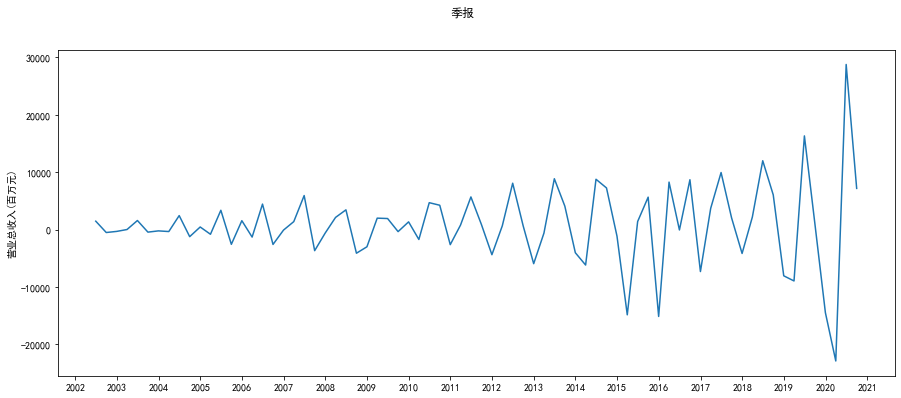

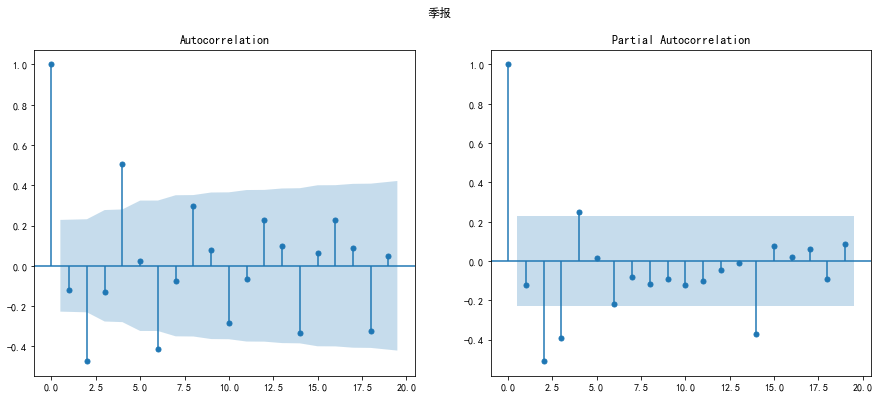

,value
Test Statistic Value,-3.199304
p-value,0.020025
Lags Used,5
Number of Observations Used,68
Critical Value(1%),-3.530399
Critical Value(5%),-2.905087
Critical Value(10%),-2.590001


In [11]:
quarter.diff()
quarter.baseShow(1)
quarter.acfShow(1)
quarter.dickey(1)

## 半年报做一阶差分

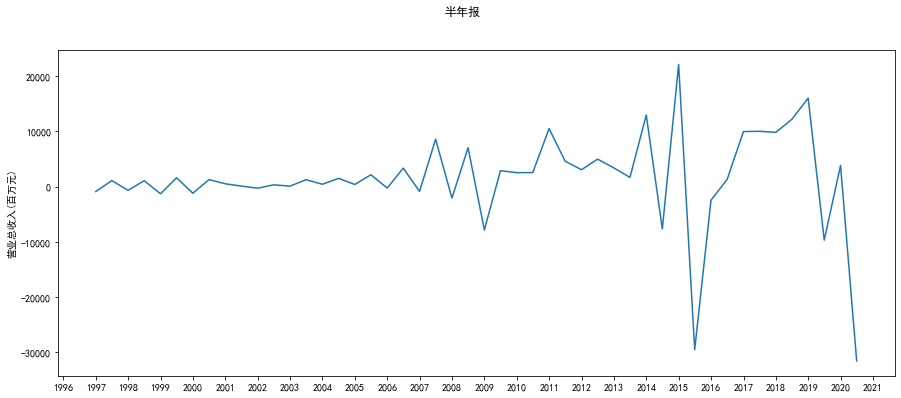

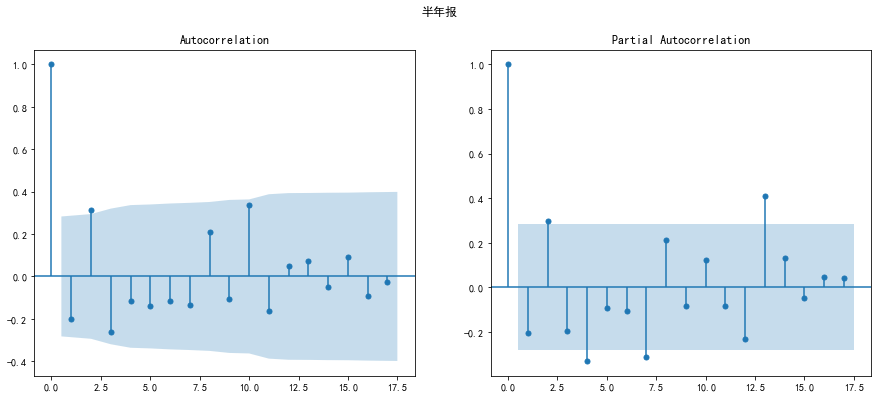

,value
Test Statistic Value,-4.477668
p-value,0.000216
Lags Used,6
Number of Observations Used,41
Critical Value(1%),-3.600983
Critical Value(5%),-2.935135
Critical Value(10%),-2.605963


In [12]:
semiannum.diff()
semiannum.baseShow(1)
semiannum.acfShow(1)
semiannum.dickey(1)

差分后，相对比较显著了

# 获取一下最佳p和q


## 季报order热力图

C:\Users\thales\.conda\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
C:\Users\thales\.conda\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
C:\Users\thales\.conda\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
C:\Users\thales\.conda\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
C:\Users\thales\.conda\envs\ml\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'availab

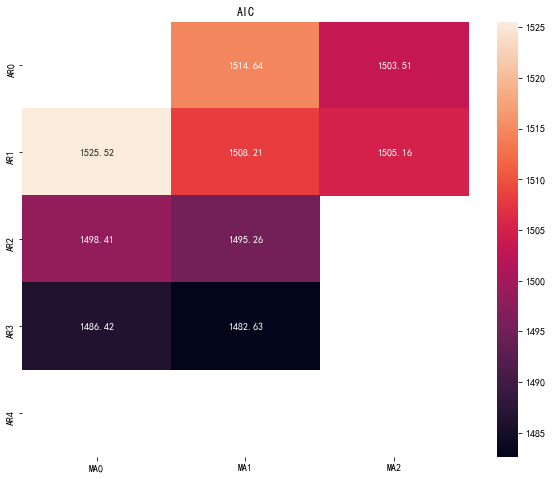

In [13]:
quarter.thermodynamicOrder(4,2,1)

## qq残差图

C:\Users\thales\.conda\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


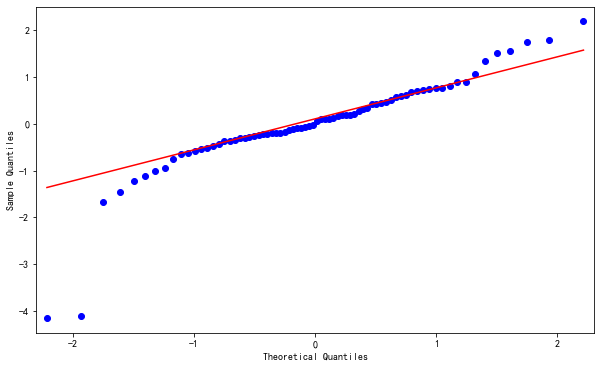

In [14]:
quarter.arma((3, 1), 1)
quarter.qqShow(1)

## 半年报order热力图

C:\Users\thales\.conda\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 2Q-DEC will be used.
  % freq, ValueWarning)
C:\Users\thales\.conda\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 2Q-DEC will be used.
  % freq, ValueWarning)
C:\Users\thales\.conda\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 2Q-DEC will be used.
  % freq, ValueWarning)
C:\Users\thales\.conda\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 2Q-DEC will be used.
  % freq, ValueWarning)
C:\Users\thales\.conda\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 2Q-DE

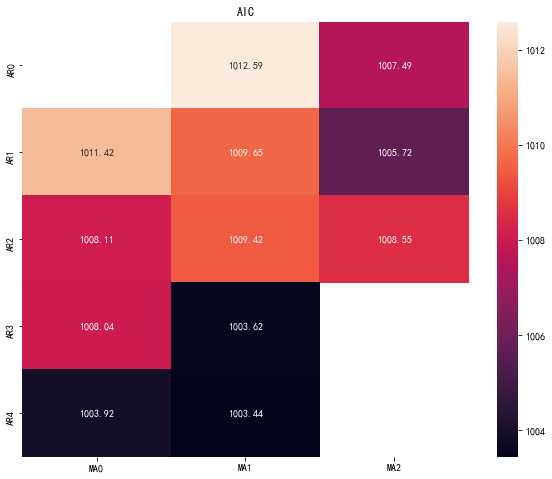

In [15]:
semiannum.thermodynamicOrder(4,2,1)

## qq残差图

C:\Users\thales\.conda\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 2Q-DEC will be used.
  % freq, ValueWarning)


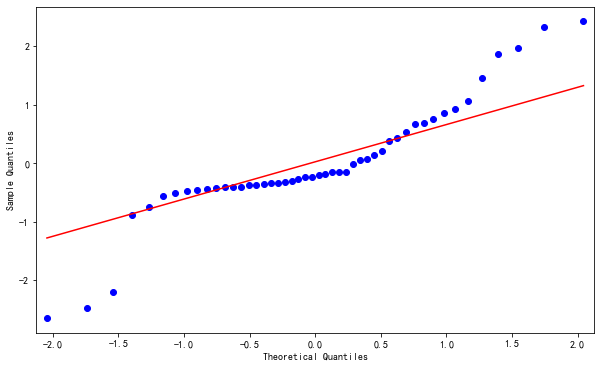

In [16]:
semiannum.arma((4,1), 1)
semiannum.qqShow(1)

# 模型预测


## 季报预测

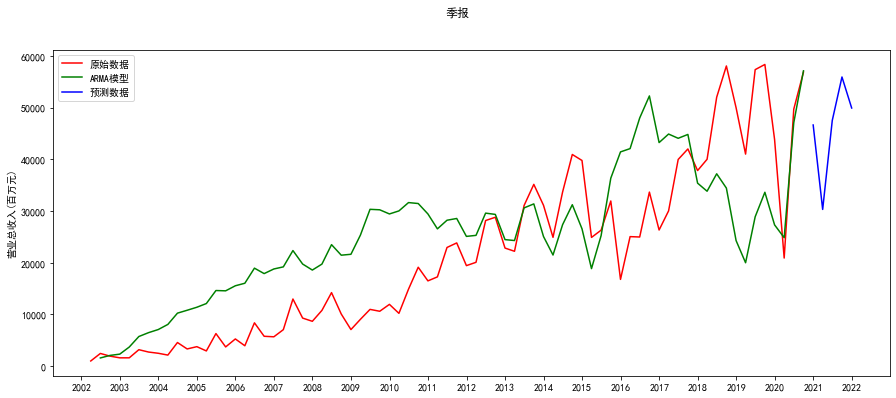

In [17]:
quarter.predict('2020-10-1', '2021-12-31')

## 半年报预测

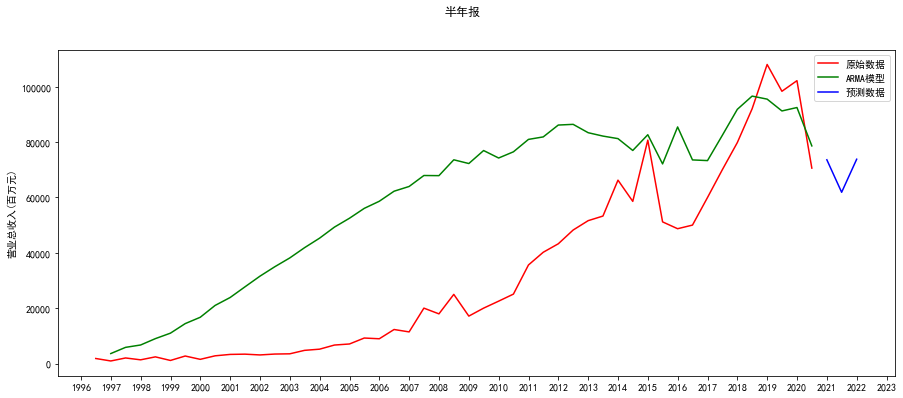

In [18]:
semiannum.predict('2020-7-1', '2021-12-31')